# Here we demonstrate auto-featurization and Deeplearning on Graphs using the Diamond Dataset

In [1]:
import graphistry
from graphistry.networks import SAGE
from graphistry.feature_utils import impute_and_scale_matrix
import graphistry.constants as config

import torch
import torch.nn.functional as F

Using backend: pytorch


In [2]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
import seaborn as sns
import graphistry
import umap
import umap.plot

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="...", password="...") 

# Load the Diamonds Dataset

In [5]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
ndf = diamonds.sample(10000)

In [7]:
ndf

,carat,cut,color,clarity,depth,table,price,x,y,z
17738,1.70,Premium,I,SI2,61.7,56.0,7140,7.66,7.57,4.70
9632,0.92,Premium,E,SI1,61.7,57.0,4637,6.32,6.20,3.86
29445,0.41,Very Good,F,SI1,62.5,58.0,702,4.74,4.77,2.97
41025,0.41,Ideal,E,VVS2,62.2,54.0,1187,4.76,4.79,2.97
32336,0.30,Ideal,E,VVS2,61.8,56.0,789,4.31,4.33,2.67
...,...,...,...,...,...,...,...,...,...,...
29958,0.35,Ideal,J,VS2,61.8,55.0,446,4.54,4.56,2.81
19890,1.20,Premium,G,VS1,60.2,60.0,8442,6.82,6.87,4.12
19178,1.46,Premium,G,SI2,59.5,59.0,7931,7.34,7.29,4.35
22661,1.26,Ideal,F,VS2,61.5,56.0,10709,6.97,7.01,4.30


In [8]:
use_columns = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

# We use kbins scaling to bin the diamond prices

In [9]:
n_bins = 7
klabels, kimputer, kscaler = \
impute_and_scale_matrix(ndf.price.values.reshape(-1, 1), use_scaler="kbins", impute=False, n_bins=n_bins)
klabels[:10].T[0]

[feature_utils.py:300 - impute_and_scale_matrix() ]
   Applying kbins-Scaling



array([2., 1., 0., 0., 0., 5., 0., 0., 0., 1.])

In [10]:
y=pd.DataFrame({'price': klabels.T[0]})

In [11]:
y

,price
0,2.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
9995,0.0
9996,3.0
9997,2.0
9998,3.0


In [12]:
# instantiate the graphistry instance
g = graphistry.nodes(ndf)

In [13]:
supervised = False
# we choose to featurize without the price information as part of the target when supervised=False
# we do this to see how well the blind features work in modeling below
if supervised:
    g2 = g.featurize(y=y, use_scaler='robust', use_columns=use_columns)
else:
    g2 = g.featurize(use_scaler='robust', use_columns=use_columns)

[feature_utils.py:861 - get_dataframe_columns() ]
   returning DataFrame with columns `['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']`

[feature_utils.py:495 -  get_textual_columns() ]
   No Textual Columns were found

[feature_utils.py:653 - process_dirty_dataframes() ]
   Encoding DataFrame might take a few minutes --------

[feature_utils.py:659 - process_dirty_dataframes() ]
   -Shape of data (10000, 24)


[feature_utils.py:660 - process_dirty_dataframes() ]
   -Transformers: 
[('low_card_cat', OneHotEncoder(), ['cut', 'color', 'clarity'])]


[feature_utils.py:661 - process_dirty_dataframes() ]
   -Transformed Columns: 
['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']...


[feature_utils.py:662 - process_dirty_dataframes() ]
   --Fitting on Data

In [14]:
g2.node_features.describe()

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,carat,depth,table,z
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.032900,0.091400,0.393600,0.251600,0.230500,0.13180,0.179000,0.181500,0.209600,0.151500,...,0.249800,0.168900,0.152800,0.223300,0.066200,0.093600,0.134996,-0.026407,0.153453,0.009042
std,0.178384,0.288192,0.488572,0.433954,0.421174,0.33829,0.383371,0.385451,0.407043,0.358553,...,0.432919,0.374682,0.359813,0.416479,0.248644,0.291286,0.724397,0.966786,0.746005,0.618500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.796880,-7.333330,-4.666670,-3.180180
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.484370,-0.533330,-0.333330,-0.549550
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.515630,0.466670,0.666670,0.450450
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.593750,11.466670,7.333330,2.135140


In [16]:
if supervised:
    # Here we use the target y in the umap, as it produces better edges_dataframe
    g3 = g2.umap(scale=1, y=y, metric='euclidean', n_neighbors=30, local_connectivity=30)
else:
    # here we don't and this produces less fidelity clustering, but still good DGL training!
    g3 = g2.umap(scale=1, y=None, metric='euclidean', n_neighbors=30, local_connectivity=30)

[feature_utils.py:1140 -                 umap() ]
   Relabeling nodes

[feature_utils.py:995 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Found Node features in `res`

[feature_utils.py:1009 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Fetching `node_target` in `res`. Target is type <class 'NoneType'>

[umap_utils.py:92 -                  fit() ]
   Starting UMAP-ing data of shape (10000, 24)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[umap_utils.py:105 -      _edge_influence() ]
   Calculating weighted adjacency (edge) DataFrame

[umap_utils.py:96 -                  fit() ]
   -UMAP-ing took 1.65 minutes total

[umap_utils.py:97 -                  fit() ]
    - or 6073.78 rows per minute

[feature_utils.py:829 - prune_weighted_edges_df_and_relabel_nodes() ]
   edge weights: mean(1.00), std(0.00), max(1.0), min(1.00), thresh(1.00)

[feature_utils.py:835 - prune_weighted_edges_df_and_relabel_nodes() ]
   Prunin

Unsupervised UMAP Clustering


<AxesSubplot:>

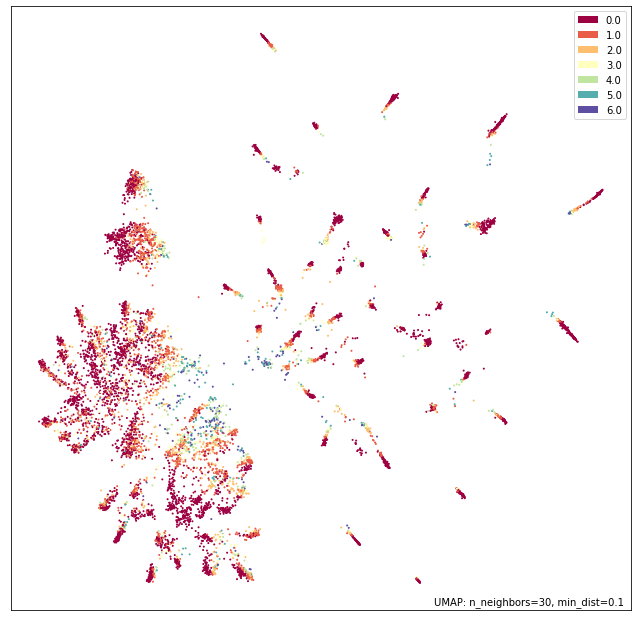

In [17]:
print(f'Supervised UMAP Clustering' if supervised else 'Unsupervised UMAP Clustering')
umap.plot.points(g3._umap, labels=klabels.T[0])

In [18]:
g3.plot()

In [19]:
g4=g3.filter_edges(scale=0, inplace=False)
#g3.filter_edges(scale=1, inplace=True) # this doesn't write to g3 as expected...FIXME

[feature_utils.py:829 - prune_weighted_edges_df_and_relabel_nodes() ]
   edge weights: mean(1.00), std(0.00), max(1.0), min(1.00), thresh(1.00)

[feature_utils.py:835 - prune_weighted_edges_df_and_relabel_nodes() ]
   Pruning weighted edge DataFrame from 376,528 to 376,528 edges.

[feature_utils.py:1225 -   _bind_xy_from_umap() ]
   Wrote new edges_dataframe from UMAP embedding of shape (376528, 3)



In [20]:
g4._edges.shape

(376528, 3)

In [21]:
g4.plot()

<AxesSubplot:>

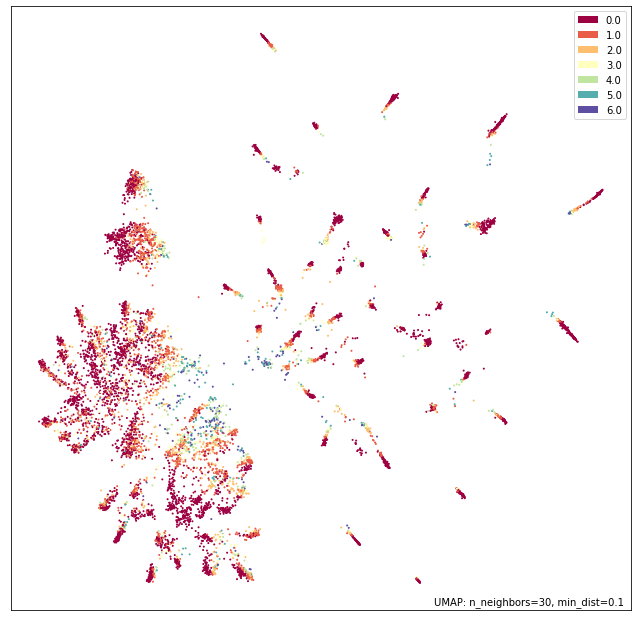

In [22]:
umap.plot.points(g4._umap, labels=klabels.T[0])

# How well do node features predict price?

In [23]:
X = g4.node_features

In [24]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


rclf = RandomForestRegressor()
clf = RandomForestClassifier()

a, b, c, d = train_test_split(X, ndf.price.values, train_size=0.8)

In [25]:
# regression works well
rclf.fit(a, c)
rclf.score(b, d)

0.9769398312751788

In [26]:
regressive_preds = rclf.predict(b)

In [27]:
# shows that the ME on price predictions is about 600 dollars...
r2_score(d, regressive_preds), mean_absolute_error(d, regressive_preds), mean_squared_error(d, regressive_preds)**0.5

(0.9769398312751788, 309.7679247261905, 585.4799715532351)

In [28]:
# let's do it for the classification version
a2, b2, c2, d2 = train_test_split(X, y.values, train_size=0.8)
clf.fit(a2, c2)
clf.score(b2, d2) # over n_bins

0.885

In [29]:
print(classification_report(d2, clf.predict(b2)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1106
         1.0       0.87      0.88      0.87       416
         2.0       0.81      0.81      0.81       211
         3.0       0.70      0.74      0.72       108
         4.0       0.55      0.49      0.52        73
         5.0       0.51      0.54      0.53        48
         6.0       0.55      0.42      0.48        38

    accuracy                           0.89      2000
   macro avg       0.71      0.69      0.70      2000
weighted avg       0.88      0.89      0.88      2000



## This does well with low false positives, for the most part (ie, one doesn't want to sell a high value diamond for a low price)

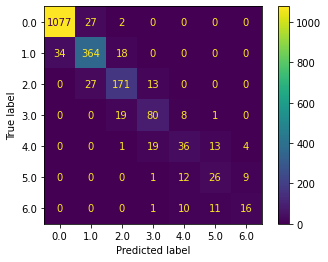

In [30]:
ConfusionMatrixDisplay.from_predictions(d2, clf.predict(b2))

# Let's turn our explicit node data and implicit edge data into a DGL graph
## Once we have the graph we can train a model for price/category prediction

In [31]:
g5 = g4.build_dgl_graph(config.IMPLICIT_NODE_ID, 
                    y_nodes=y, 
                    use_node_columns=use_columns, 
                    use_node_scaler='robust', 
                    use_edge_scaler='robust')

[dgl_utils.py:119 - _convert_edgeDF_to_DGL() ]
   converting edge DataFrame to DGL graph

[dgl_utils.py:80 - _remove_edges_not_in_nodes() ]
   Length of edge DataFrame 376528

[dgl_utils.py:86 - _remove_edges_not_in_nodes() ]
   Length of edge DataFrame 376528 after pruning

[dgl_utils.py:34 -  pandas_to_dgl_graph() ]
   Graph Type: <class 'dgl.heterograph.DGLHeteroGraph'>

[dgl_utils.py:97 - _check_nodes_lineup_with_edges() ]
   10000 entities from column _n
 with 10000 unique entities

[dgl_utils.py:144 - _featurize_nodes_to_dgl() ]
   Running Node Featurization for DGL Graph

[feature_utils.py:995 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Found Node features in `res`

[dgl_utils.py:165 - _featurize_edges_to_dgl() ]
   Running Edge Featurization for DGL Graph

[feature_utils.py:1035 - _featurize_or_get_edges_dataframe_if_X_is_None() ]
   Calling `featurize` to create data matrix `X` over edges DataFrame

[feature_utils.py:738 - process_edge_dataframes() ]
   Encoding Ed

In [32]:
G = g5.DGL_graph

In [33]:
## we want to turn node_labels into indicator variables for later
lbin = LabelBinarizer()

In [34]:
node_labels = G.ndata['target']
labels = lbin.fit_transform(node_labels)
labels = torch.tensor(labels).float()

node_features = G.ndata['feature'].float()
n_features = node_features.shape[1]

latent_dim = 42
n_labels = int(node_labels.max().item() + 1)

train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

# Create the model

In [35]:
model = SAGE(in_feats=n_features, hid_feats=latent_dim, out_feats=n_labels)

pred = model(G, node_features) # untrained logits
pred.shape

torch.Size([10000, 7])

In [36]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels.argmax(1))
        return correct.item() * 1.0 / len(labels)

# Training the model

In [37]:
opt = torch.optim.Adam(model.parameters())

for epoch in range(2001):
    model.train()
    # forward propagation by using all nodes
    logits = model(G, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    # compute validation accuracy
    acc = evaluate(model, G, node_features, labels, test_mask)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch %200==0:
        print(f'epoch: {epoch} -------\nloss: {loss.item():.4f}')
        print(f'\tAcc: {acc:.4f}')


loss: 2.0410
	Acc: 0.3021
loss: 0.7160
	Acc: 0.7466
loss: 0.5014
	Acc: 0.8158
loss: 0.3985
	Acc: 0.8625
loss: 0.3361
	Acc: 0.8767
loss: 0.2951
	Acc: 0.8831
loss: 0.2675
	Acc: 0.8865
loss: 0.2476
	Acc: 0.8900
loss: 0.2318
	Acc: 0.8924
loss: 0.2188
	Acc: 0.8905


In [38]:
logits = model(G, node_features)
preds = logits.argmax(1)

preds_true = labels.argmax(1)

# how well does it perform on hold out set? Given more edges, 
# it does slightly better than RF
aa, bb = preds_true[test_mask], preds[test_mask]
print(classification_report(aa, bb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1155
           1       0.89      0.89      0.89       419
           2       0.83      0.82      0.82       211
           3       0.67      0.75      0.71        97
           4       0.51      0.56      0.53        64
           5       0.49      0.43      0.46        54
           6       0.58      0.50      0.54        36

    accuracy                           0.90      2036
   macro avg       0.71      0.70      0.70      2036
weighted avg       0.90      0.90      0.90      2036



In [39]:
# compare to RF, we want highest Recall in the more expensive classes (4-6)
print(classification_report(d2, clf.predict(b2)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1106
         1.0       0.87      0.88      0.87       416
         2.0       0.81      0.81      0.81       211
         3.0       0.70      0.74      0.72       108
         4.0       0.55      0.49      0.52        73
         5.0       0.51      0.54      0.53        48
         6.0       0.55      0.42      0.48        38

    accuracy                           0.89      2000
   macro avg       0.71      0.69      0.70      2000
weighted avg       0.88      0.89      0.88      2000



# We would like to minimize high value diamonds being labeled as lower value (hence, we want smallest values possible on the lower triangular part of the confusion matrix)

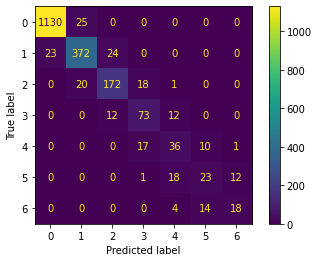

In [40]:
ConfusionMatrixDisplay.from_predictions(aa, bb)

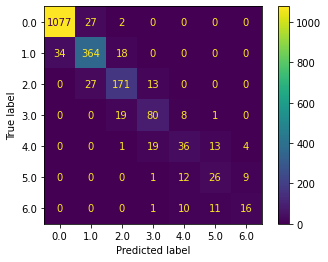

In [41]:
# compared to RF
ConfusionMatrixDisplay.from_predictions(d2, clf.predict(b2))

## lets see ROC/AUC scores over multiclass

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Learn to predict each class against the other
clf2 = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=42)
)

# use the label binarizer from before
c22 = lbin.transform(c2)
d22 = lbin.transform(d2)

y_score = clf2.fit(a2, c22).decision_function(b2)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(d22[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(d22.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

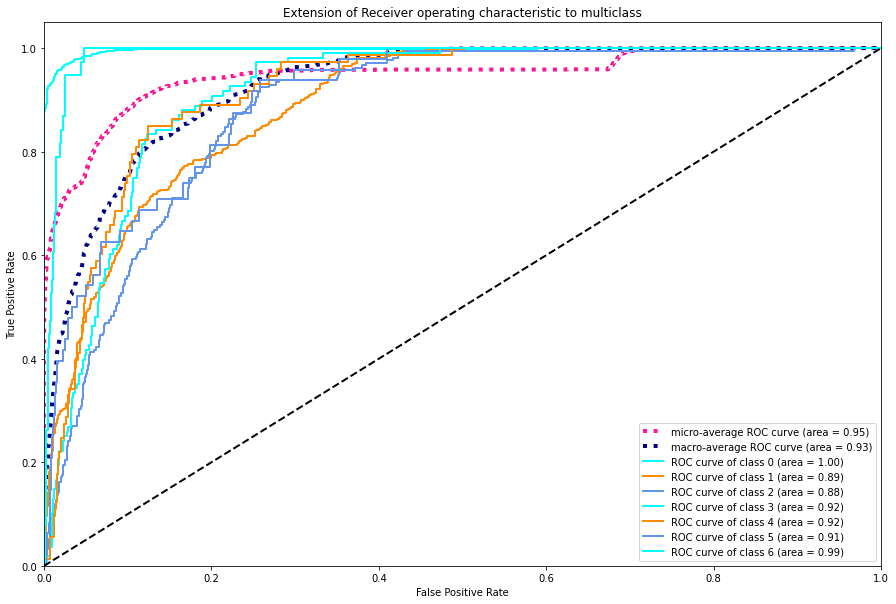

In [51]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_labels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_labels), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [52]:
clf2.score(b2, lbin.transform(d2))

0.628